# Load in Data

In [4]:
"""
For this new random forests, we use the features computed in feature_extractor.py
    -'title'  # overlap between titles
    -'year'  # time difference
    -'authors'  # authors in common
    
    ## Abstract embedding
    -'tf-idf'  # tf-idf cosine similarity
    -'Doc2Vec'  # Doc2Vec cosine similarity
    
    ## Features computed on the connection between documents graph (represented by the adjacency matrix D)
    -'deg_in(s)'
    -'deg_in(t)'
    -'deg_out(s)'
    -'deg_out(t)'
    -'(DD)_st'
    -'(D D.T)_st'
    -'(D.T D)_st'
    -'(DDD)_st'
    -'(D.T DD)_st'
    -'(D D.T D)_st'
    -'(DD D.T)_st'
    
    ## Features computed on the connection between authors graph (represented by the adjacency matrix A)
    -'graph_author_feature'  # number of citations between both group of authors
    -'a_degree_in_source'  # sum of all citation received by the authors of the source document
    -'a_degree_in_target'  # sum of all citation received by the authors of the targe document
    -'a_degree_out_source'  # sum of all citation done by the authors of the source document
    -'a_degree_out_target'  # sum of all citation done by the authors of the target document
    -'f_AA'  # sum of the coefficient of the matrix AA over all position where i and j are respectively authors of the source and target documents
    -'f_AAt' # same with another matrix ...
    -'f_AtA'
    -'f_AAA'
    -'f_AtAA'
    -'f_AAtA'
    -'f_AAAt'
    
    ## Others
    -'title_cited'  # binary value if the title of the target is found in the abstract of the source
    -'journals'  # number of journals in common when the overlap is complete for one of the article

"""

import pickle
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import csv

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers


## import features computed previously
feature_list = ["title", "year", "authors", "tf-idf", "Doc2Vec", "deg_in(s)", "deg_in(t)", "deg_out(s)", "deg_out(t)", "(DD)_st", "(D D.T)_st", "(D.T D)_st", "(DDD)_st", "(D.T DD)_st", "(D D.T D)_st", "(DD D.T)_st", "graph_author_feature", "a_degree_in_source", "a_degree_in_target", "a_degree_out_source", "a_degree_out_target", "f_AA", "f_AAt", "f_AtA", "f_AAA", "f_AtAA", "f_AAtA", "f_AAAt", "title_cited", "journals"]
# to_keep = feature_list
to_keep = ["title", "year", "authors", "tf-idf", "Doc2Vec", "deg_in(t)", "deg_out(s)", "(DD)_st", "(D D.T)_st", "(D.T D)_st", "(DDD)_st", "(D.T DD)_st", "(D D.T D)_st", "(DD D.T)_st"]
# to_keep = ["title", "year", "authors", "tf-idf", "Doc2Vec", "deg_in(t)", "deg_out(s)", "(D.T DD)_st", "(D D.T D)_st", "(DD D.T)_st", "a_degree_in_target", "a_degree_out_source", "f_AtAA", "f_AAtA", "f_AAAt", "title_cited", "journals"]
#, "(DD)_st", "(D D.T)_st", "(D.T D)_st", "(DDD)_st", "a_degree_in_source", "a_degree_out_target", "f_AA", "f_AAt", "f_AtA", "f_AAA"]
to_keep_indices = [feature_list.index(feature) for feature in to_keep]

train_features = pickle.load(open("features/training_features_split.pkl",'rb'))[:,to_keep_indices]
train_labels = pickle.load(open("features/training_labels_split.pkl",'rb'))
testing_features = pickle.load(open("features/testing_features_split.pkl",'rb'))
# train_features[:2]

# Data Preparation

In [5]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size = 0.2, random_state = 42)

In [6]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', len(train_labels))
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', len(test_labels))
print('Nb of Features: {} out of {}'.format(len(to_keep), len(feature_list)))



Training Features Shape: (147721, 14)
Training Labels Shape: 147721
Testing Features Shape: (36931, 14)
Testing Labels Shape: 36931
Nb of Features: 14 out of 30


### Examine the Default Random Forest to Determine Parameters

We will use these parameters as a starting point. I relied on the [sklearn random forest documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to determine which features to change and the available options.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Evaluation Function

In [8]:
def evaluate(model, test_features, test_labels, train_features, train_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels).sum()  # nb of errors
    test_accuracy = (1 - 1. * errors / len(test_features)) * 100
    print('Test accuracy = {:0.2f}%. '.format(test_accuracy), end='')
    predictions = model.predict(train_features)
    errors = abs(predictions - train_labels).sum()  # nb of errors
    accuracy = (1 - 1. * errors / len(train_features)) * 100
    print('Train accuracy = {:0.2f}%.'.format(accuracy))
    return test_accuracy

from sklearn.metrics import balanced_accuracy_score, accuracy_score

def evaluate2(model, test_features, test_labels, train_features, train_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(100*accuracy_score(test_labels, predictions)))
    predictions = model.predict(train_features)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(100*accuracy_score(train_labels, predictions)))

## Custom random search

In [21]:
# Number of trees in random forest
n_estimators = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70]  # 100, 200, 400, 700, 1000, 1500, 2000]
# Number of features to consider at every split
max_features = [1, 2, 3, 8, 'sqrt', None]
# Maximum number of levels in tree
max_depths = [1, 2, 3, 4, 5, 6, 7]  #, 10, 13, 17, 20, 25]
max_depths.append(None)
# Minimum number of samples required to split a node
min_samples_splits = [2, 5, 10, 20, 30, 40, 50, 60, 70]  #100, 200, 500, 1000, 2000, 5000, 10000]
# Minimum number of samples required at each leaf node
min_samples_leaves = [1, 2, 4, 8, 16, 32, 64, 128]  #, 256, 512, 1024, 2048, 4096]
# Method of selecting samples for training each tree
bootstraps = [True, False]

nb_of_cases = len(n_estimators) * len(max_features) * len(max_depths) * len(min_samples_splits) * len(min_samples_leaves) * len(bootstraps)
print("Nombre d'estimateurs: {}".format(nb_of_cases))

threshold = 0.005  # RATIO OF TESTED PARAMETERS
print("Nombre d'estimateurs testés en théorie: {}".format(nb_of_cases * threshold))

cpt = 0
maxValuationAccuracy = 0
bestParams = " "
resDict = {}
for n_estimator in n_estimators:
    for max_feature in max_features:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leaves:
                    for bootstrap in bootstraps:
                        if np.random.rand() < threshold:
                            cpt += 1
                            params = "{}, {}, {}, {}, {}, {}".format(n_estimator, max_feature, max_depth, min_samples_split, min_samples_leaf, bootstrap)
                            print("{}ème itérateur: {}".format(cpt, params))
                            model = RandomForestClassifier(
                                random_state = 42, 
                                n_estimators = n_estimator, 
                                max_features = max_feature,
                                max_depth = max_depth,
                                min_samples_split = min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                bootstrap = bootstrap,
                                n_jobs=6,
                                verbose = 1
                            )
                            model.fit(train_features, train_labels)
                            acc = evaluate(model, test_features, test_labels, train_features, train_labels)
                            if acc > maxValuationAccuracy:
                                maxValuationAccuracy = acc
                                bestParams = params
                            if acc not in resDict:
                                resDict[acc] = []
                            resDict[acc].append(params)
                            print("Best accuracy reached so far: {} for params: {}".format(maxValuationAccuracy, bestParams))


print("Nombre d'estimateurs testés: {}".format(cpt))
res = "Best accuracy reached: {} for params: {}".format(maxValuationAccuracy, bestParams)
print(res)
resDict


Nombre d'estimateurs: 103680
Nombre d'estimateurs testés en théorie: 518.4
1ème itérateur: 1, 1, 1, 5, 1, False
Test accuracy = 62.94%. Train accuracy = 63.15%.
Best accuracy reached so far: 62.94170209309252 for params: 1, 1, 1, 5, 1, False
2ème itérateur: 1, 1, 1, 20, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs

Test accuracy = 62.94%. Train accuracy = 63.15%.
Best accuracy reached so far: 62.94170209309252 for params: 1, 1, 1, 5, 1, False
3ème itérateur: 1, 1, 2, 40, 8, False
Test accuracy = 70.88%. Train accuracy = 71.04%.
Best accuracy reached so far: 70.88353957379978 for params: 1, 1, 2, 40, 8, False
4ème itérateur: 1, 1, 4, 50, 1, True


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 88.55%. Train accuracy = 88.87%.
Best accuracy reached so far: 88.55433104979556 for params: 1, 1, 4, 50, 1, True
5ème itérateur: 1, 1, 10, 60, 1, True
Test accuracy = 91.60%. Train accuracy = 91.90%.
Best accuracy reached so far: 91.59784462917332 for params: 1, 1, 10, 60, 1, True
6ème itérateur: 1, 1, 20, 30, 1, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.19%. Train accuracy = 95.10%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
7ème itérateur: 1, 1, 20, 40, 2, True
Test accuracy = 93.49%. Train accuracy = 94.18%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
8ème itérateur: 1, 1, 20, 60, 16, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Test accuracy = 92.94%. Train accuracy = 93.28%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
9ème itérateur: 1, 1, None, 10, 16, False
Test accuracy = 91.65%. Train accuracy = 92.09%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
10ème itérateur: 1, 2, 1, 60, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished


Test accuracy = 62.94%. Train accuracy = 63.15%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
11ème itérateur: 1, 2, 4, 20, 128, True
Test accuracy = 87.38%. Train accuracy = 87.54%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
12ème itérateur: 1, 2, 5, 40, 2, True


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 90.41%. Train accuracy = 90.41%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
13ème itérateur: 1, 2, 10, 2, 1, True
Test accuracy = 92.91%. Train accuracy = 93.19%.
Best accuracy reached so far: 94.18916357531613 for params: 1, 1, 20, 30, 1, True
14ème itérateur: 1, 2, 13, 20, 64, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.25%. Train accuracy = 94.34%.
Best accuracy reached so far: 94.24873412580217 for params: 1, 2, 13, 20, 64, True
15ème itérateur: 1, 2, 13, 40, 1, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.70%. Train accuracy = 95.28%.
Best accuracy reached so far: 94.6982210067423 for params: 1, 2, 13, 40, 1, False
16ème itérateur: 1, 2, 17, 40, 8, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test accuracy = 94.42%. Train accuracy = 94.99%.
Best accuracy reached so far: 94.6982210067423 for params: 1, 2, 13, 40, 1, False
17ème itérateur: 1, 2, 20, 20, 64, True
Test accuracy = 93.48%. Train accuracy = 93.70%.
Best accuracy reached so far: 94.6982210067423 for params: 1, 2, 13, 40, 1, False
18ème itérateur: 1, 3, 3, 60, 8, False


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 86.86%. Train accuracy = 87.10%.
Best accuracy reached so far: 94.6982210067423 for params: 1, 2, 13, 40, 1, False
19ème itérateur: 1, 3, 10, 2, 128, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.53%. Train accuracy = 94.63%.
Best accuracy reached so far: 94.6982210067423 for params: 1, 2, 13, 40, 1, False
20ème itérateur: 1, 3, 10, 5, 32, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.95%. Train accuracy = 95.22%.
Best accuracy reached so far: 94.95004197016057 for params: 1, 3, 10, 5, 32, False
21ème itérateur: 1, 3, 17, 60, 32, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.08%. Train accuracy = 95.31%.
Best accuracy reached so far: 95.08272183260675 for params: 1, 3, 17, 60, 32, True
22ème itérateur: 1, 3, None, 40, 128, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.75%. Train accuracy = 94.89%.
Best accuracy reached so far: 95.08272183260675 for params: 1, 3, 17, 60, 32, True
23ème itérateur: 1, 3, None, 70, 1, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test accuracy = 95.46%. Train accuracy = 96.44%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
24ème itérateur: 1, 8, 1, 10, 4, True
Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
25ème itérateur: 1, 8, 3, 30, 4, False


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished


Test accuracy = 94.36%. Train accuracy = 94.52%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
26ème itérateur: 1, 8, 3, 30, 16, False


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished


Test accuracy = 94.36%. Train accuracy = 94.52%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
27ème itérateur: 1, 8, 3, 70, 8, False


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.36%. Train accuracy = 94.52%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
28ème itérateur: 1, 8, 5, 60, 128, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.16%. Train accuracy = 95.27%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
29ème itérateur: 1, 8, 7, 20, 32, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.41%. Train accuracy = 95.39%.
Best accuracy reached so far: 95.45909940158674 for params: 1, 3, None, 70, 1, False
30ème itérateur: 1, 8, 17, 30, 32, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.23%. Train accuracy = 96.58%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
31ème itérateur: 1, 8, 17, 60, 2, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Test accuracy = 96.17%. Train accuracy = 97.00%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
32ème itérateur: 1, sqrt, 2, 60, 8, True
Test accuracy = 90.30%. Train accuracy = 90.29%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
33ème itérateur: 1, sqrt, 3, 30, 64, False


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_job

Test accuracy = 91.53%. Train accuracy = 91.54%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
34ème itérateur: 1, sqrt, 3, 50, 1, True
Test accuracy = 91.53%. Train accuracy = 91.54%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
35ème itérateur: 1, sqrt, 10, 30, 32, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.57%. Train accuracy = 95.79%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
36ème itérateur: 1, sqrt, 13, 40, 8, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.69%. Train accuracy = 96.15%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
37ème itérateur: 1, sqrt, 13, 70, 128, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.82%. Train accuracy = 95.90%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
38ème itérateur: 1, sqrt, 17, 30, 64, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.56%. Train accuracy = 95.75%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
39ème itérateur: 1, sqrt, 17, 40, 128, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.30%. Train accuracy = 95.36%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
40ème itérateur: 1, sqrt, 17, 70, 8, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.10%. Train accuracy = 96.56%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
41ème itérateur: 1, sqrt, 25, 50, 32, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.57%. Train accuracy = 95.88%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
42ème itérateur: 1, sqrt, 25, 70, 32, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.00%. Train accuracy = 96.30%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
43ème itérateur: 1, sqrt, None, 40, 8, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.76%. Train accuracy = 96.21%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
44ème itérateur: 1, None, 5, 60, 1, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.86%. Train accuracy = 96.01%.
Best accuracy reached so far: 96.22810105331564 for params: 1, 8, 17, 30, 32, False
45ème itérateur: 1, None, 10, 2, 2, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.26%. Train accuracy = 96.69%.
Best accuracy reached so far: 96.25517857626384 for params: 1, None, 10, 2, 2, True
46ème itérateur: 1, None, 10, 5, 8, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.37%. Train accuracy = 96.65%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
47ème itérateur: 1, None, 17, 40, 32, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.27%. Train accuracy = 96.56%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
48ème itérateur: 1, None, 20, 20, 16, False


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.33%. Train accuracy = 97.27%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
49ème itérateur: 1, None, 20, 40, 8, True


[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.23%. Train accuracy = 96.78%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
50ème itérateur: 2, 1, 2, 40, 128, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 71.79%. Train accuracy = 71.98%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
51ème itérateur: 2, 1, 3, 2, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 85.69%. Train accuracy = 85.66%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
52ème itérateur: 2, 1, 4, 50, 8, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 91.74%. Train accuracy = 91.79%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
53ème itérateur: 2, 1, 4, 60, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 91.74%. Train accuracy = 91.79%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
54ème itérateur: 2, 1, 5, 60, 32, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 89.61%. Train accuracy = 89.81%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
55ème itérateur: 2, 1, 13, 5, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.60%. Train accuracy = 93.92%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
56ème itérateur: 2, 1, None, 5, 16, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 94.51%. Train accuracy = 94.85%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
57ème itérateur: 2, 2, 1, 5, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 64.38%. Train accuracy = 64.75%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
58ème itérateur: 2, 2, 4, 40, 64, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 90.59%. Train accuracy = 90.68%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
59ème itérateur: 2, 2, 5, 70, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 92.43%. Train accuracy = 92.58%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
60ème itérateur: 2, 2, 7, 30, 1, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.23%. Train accuracy = 93.47%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
61ème itérateur: 2, 2, 25, 5, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 94.61%. Train accuracy = 94.88%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
62ème itérateur: 2, 2, None, 50, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 94.61%. Train accuracy = 94.88%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
63ème itérateur: 2, 2, None, 70, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.64%. Train accuracy = 96.17%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
64ème itérateur: 2, 3, 1, 40, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 88.40%. Train accuracy = 88.57%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
65ème itérateur: 2, 3, 3, 50, 4, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 88.76%. Train accuracy = 89.07%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
66ème itérateur: 2, 3, 3, 70, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 88.76%. Train accuracy = 89.07%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
67ème itérateur: 2, 3, 4, 2, 32, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.09%. Train accuracy = 93.33%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
68ème itérateur: 2, 3, 4, 70, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.09%. Train accuracy = 93.33%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
69ème itérateur: 2, 3, 5, 2, 16, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.59%. Train accuracy = 93.66%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
70ème itérateur: 2, 3, 5, 20, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.59%. Train accuracy = 93.66%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
71ème itérateur: 2, 3, 5, 30, 2, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.59%. Train accuracy = 93.66%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
72ème itérateur: 2, 3, 10, 2, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.22%. Train accuracy = 95.42%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
73ème itérateur: 2, 3, 10, 30, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.38%. Train accuracy = 95.57%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
74ème itérateur: 2, 3, 10, 40, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.71%. Train accuracy = 96.03%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
75ème itérateur: 2, 3, 13, 20, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.90%. Train accuracy = 96.38%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
76ème itérateur: 2, 3, 13, 30, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.88%. Train accuracy = 96.73%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
77ème itérateur: 2, 3, 17, 30, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.55%. Train accuracy = 95.77%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
78ème itérateur: 2, 3, 20, 20, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.80%. Train accuracy = 96.09%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
79ème itérateur: 2, 3, None, 10, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.85%. Train accuracy = 97.15%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
80ème itérateur: 2, 3, None, 70, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.99%. Train accuracy = 96.40%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
81ème itérateur: 2, 8, 2, 20, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.98%. Train accuracy = 94.14%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
82ème itérateur: 2, 8, 7, 50, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.82%. Train accuracy = 95.89%.
Best accuracy reached so far: 96.37431967723593 for params: 1, None, 10, 5, 8, True
83ème itérateur: 2, 8, 13, 30, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.51%. Train accuracy = 96.97%.
Best accuracy reached so far: 96.51241504427175 for params: 2, 8, 13, 30, 4, True
84ème itérateur: 2, 8, 17, 50, 32, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.52%. Train accuracy = 96.95%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
85ème itérateur: 2, 8, 20, 50, 128, True


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.14%. Train accuracy = 96.24%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
86ème itérateur: 2, sqrt, 1, 20, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 90.41%. Train accuracy = 90.52%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
87ème itérateur: 2, sqrt, 1, 40, 64, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 90.41%. Train accuracy = 90.52%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
88ème itérateur: 2, sqrt, 1, 60, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 90.41%. Train accuracy = 90.52%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
89ème itérateur: 2, sqrt, 3, 5, 4, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Test accuracy = 93.57%. Train accuracy = 93.53%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
90ème itérateur: 2, sqrt, 3, 10, 128, True


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.25%. Train accuracy = 93.32%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
91ème itérateur: 2, sqrt, 3, 60, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 93.25%. Train accuracy = 93.32%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
92ème itérateur: 2, sqrt, 10, 5, 32, False


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.26%. Train accuracy = 96.48%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
93ème itérateur: 2, sqrt, 10, 5, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Test accuracy = 95.92%. Train accuracy = 96.10%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
94ème itérateur: 2, sqrt, 17, 10, 1, False


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.95%. Train accuracy = 98.29%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
95ème itérateur: 2, None, 1, 30, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
96ème itérateur: 2, None, 5, 50, 8, True


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 95.90%. Train accuracy = 96.05%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
97ème itérateur: 2, None, 7, 2, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.04%. Train accuracy = 96.13%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
98ème itérateur: 2, None, 7, 50, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Test accuracy = 96.08%. Train accuracy = 96.13%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
99ème itérateur: 5, 1, 2, 50, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 76.32%. Train accuracy = 76.65%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
100ème itérateur: 5, 1, 5, 30, 128, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 91.01%. Train accuracy = 91.14%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
101ème itérateur: 5, 1, 5, 60, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 90.86%. Train accuracy = 90.90%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
102ème itérateur: 5, 1, 10, 50, 2, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 94.01%. Train accuracy = 94.41%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
103ème itérateur: 5, 1, 17, 30, 4, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.53%. Train accuracy = 96.39%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
104ème itérateur: 5, 1, 20, 40, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 94.56%. Train accuracy = 94.77%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
105ème itérateur: 5, 1, None, 50, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.91%. Train accuracy = 96.82%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
106ème itérateur: 5, 2, 2, 2, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 82.67%. Train accuracy = 82.94%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
107ème itérateur: 5, 2, 2, 20, 128, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 83.11%. Train accuracy = 83.45%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
108ème itérateur: 5, 2, 4, 10, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 91.83%. Train accuracy = 91.98%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
109ème itérateur: 5, 2, 4, 20, 4, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 91.84%. Train accuracy = 91.99%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
110ème itérateur: 5, 2, 5, 30, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 93.01%. Train accuracy = 93.23%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
111ème itérateur: 5, 2, 10, 30, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.20%. Train accuracy = 95.29%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
112ème itérateur: 5, 2, 17, 5, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.46%. Train accuracy = 97.26%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
113ème itérateur: 5, 2, 17, 70, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.98%. Train accuracy = 96.25%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
114ème itérateur: 5, 2, 25, 20, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.19%. Train accuracy = 96.94%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
115ème itérateur: 5, 3, 1, 2, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 89.64%. Train accuracy = 89.83%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
116ème itérateur: 5, 3, 1, 70, 2, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 89.64%. Train accuracy = 89.83%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
117ème itérateur: 5, 3, 1, 70, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 89.64%. Train accuracy = 89.83%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
118ème itérateur: 5, 3, 7, 5, 32, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.49%. Train accuracy = 95.51%.
Best accuracy reached so far: 96.52053830115621 for params: 2, 8, 17, 50, 32, False
119ème itérateur: 5, 3, 17, 2, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Test accuracy = 96.65%. Train accuracy = 98.10%.
Best accuracy reached so far: 96.64509490671793 for params: 5, 3, 17, 2, 4, False
120ème itérateur: 5, 3, 17, 5, 8, False


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Test accuracy = 96.72%. Train accuracy = 97.69%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
121ème itérateur: 5, 3, 25, 60, 32, False


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.44%. Train accuracy = 96.88%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
122ème itérateur: 5, 3, 25, 60, 128, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.12%. Train accuracy = 96.33%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
123ème itérateur: 5, 8, 2, 5, 16, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 93.30%. Train accuracy = 93.40%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
124ème itérateur: 5, 8, 3, 20, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 94.24%. Train accuracy = 94.38%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
125ème itérateur: 5, 8, 3, 60, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 94.21%. Train accuracy = 94.35%.
Best accuracy reached so far: 96.7209119709729 for params: 5, 3, 17, 5, 8, False
126ème itérateur: 5, 8, 13, 70, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.77%. Train accuracy = 97.05%.
Best accuracy reached so far: 96.77235926457448 for params: 5, 8, 13, 70, 32, False
127ème itérateur: 5, 8, 25, 2, 32, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.78%. Train accuracy = 96.98%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
128ème itérateur: 5, 8, 25, 60, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.78%. Train accuracy = 97.16%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
129ème itérateur: 5, sqrt, 1, 30, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 92.52%. Train accuracy = 92.57%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
130ème itérateur: 5, sqrt, 1, 40, 128, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 92.52%. Train accuracy = 92.57%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
131ème itérateur: 5, sqrt, 3, 40, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 93.71%. Train accuracy = 93.63%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
132ème itérateur: 5, sqrt, 5, 30, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.06%. Train accuracy = 95.10%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
133ème itérateur: 5, sqrt, 7, 60, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.97%. Train accuracy = 95.99%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
134ème itérateur: 5, sqrt, 7, 70, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Test accuracy = 95.82%. Train accuracy = 95.91%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
135ème itérateur: 5, sqrt, 10, 20, 4, False


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.45%. Train accuracy = 96.77%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
136ème itérateur: 5, sqrt, 10, 20, 128, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.24%. Train accuracy = 96.27%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
137ème itérateur: 5, sqrt, 10, 60, 32, True


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Test accuracy = 96.36%. Train accuracy = 96.53%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
138ème itérateur: 5, sqrt, 17, 5, 16, True


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.69%. Train accuracy = 97.13%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
139ème itérateur: 5, sqrt, 17, 70, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.61%. Train accuracy = 96.79%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
140ème itérateur: 5, None, 1, 30, 32, False


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
141ème itérateur: 5, None, 3, 10, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
142ème itérateur: 5, None, 4, 2, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 95.65%. Train accuracy = 95.71%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
143ème itérateur: 5, None, 5, 60, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


Test accuracy = 95.92%. Train accuracy = 96.07%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
144ème itérateur: 5, None, 10, 40, 64, False


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.33%. Train accuracy = 96.52%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
145ème itérateur: 5, None, 20, 60, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.71%. Train accuracy = 97.17%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
146ème itérateur: 5, None, None, 5, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.51%. Train accuracy = 96.68%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
147ème itérateur: 5, None, None, 10, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.78%. Train accuracy = 97.30%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
148ème itérateur: 5, None, None, 70, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Test accuracy = 96.68%. Train accuracy = 97.06%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
149ème itérateur: 10, 1, 3, 20, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 86.76%. Train accuracy = 87.25%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
150ème itérateur: 10, 1, 4, 60, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 90.83%. Train accuracy = 91.08%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
151ème itérateur: 10, 1, 5, 5, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 91.73%. Train accuracy = 91.89%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
152ème itérateur: 10, 1, 5, 10, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 91.77%. Train accuracy = 91.95%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
153ème itérateur: 10, 1, 7, 5, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 93.54%. Train accuracy = 93.75%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
154ème itérateur: 10, 1, 7, 10, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 93.60%. Train accuracy = 93.78%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
155ème itérateur: 10, 1, 7, 60, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 93.60%. Train accuracy = 93.78%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
156ème itérateur: 10, 1, 13, 50, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.80%. Train accuracy = 96.32%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
157ème itérateur: 10, 1, 13, 60, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.02%. Train accuracy = 95.37%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
158ème itérateur: 10, 1, 17, 30, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.65%. Train accuracy = 96.22%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
159ème itérateur: 10, 1, 20, 20, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.18%. Train accuracy = 97.28%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
160ème itérateur: 10, 1, 20, 40, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.27%. Train accuracy = 96.88%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
161ème itérateur: 10, 1, 20, 50, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.68%. Train accuracy = 94.91%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
162ème itérateur: 10, 1, 25, 40, 1, True


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.41%. Train accuracy = 97.20%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
163ème itérateur: 10, 2, 2, 30, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 90.23%. Train accuracy = 90.49%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
164ème itérateur: 10, 2, 2, 70, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 90.23%. Train accuracy = 90.49%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
165ème itérateur: 10, 2, 3, 20, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 91.38%. Train accuracy = 91.63%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
166ème itérateur: 10, 2, 4, 20, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.23%. Train accuracy = 93.27%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
167ème itérateur: 10, 2, 5, 5, 32, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.09%. Train accuracy = 94.16%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
168ème itérateur: 10, 2, 5, 40, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.54%. Train accuracy = 93.71%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
169ème itérateur: 10, 2, 5, 60, 1, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 93.86%. Train accuracy = 94.01%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
170ème itérateur: 10, 2, 7, 2, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.71%. Train accuracy = 94.86%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
171ème itérateur: 10, 2, 17, 2, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.41%. Train accuracy = 96.73%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
172ème itérateur: 10, 2, 17, 60, 128, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.09%. Train accuracy = 96.17%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
173ème itérateur: 10, 2, 25, 60, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.11%. Train accuracy = 96.25%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
174ème itérateur: 10, 2, 25, 70, 16, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.63%. Train accuracy = 97.07%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
175ème itérateur: 10, 3, 1, 70, 16, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 91.34%. Train accuracy = 91.45%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
176ème itérateur: 10, 3, 2, 40, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 93.75%. Train accuracy = 93.67%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
177ème itérateur: 10, 3, 13, 30, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.46%. Train accuracy = 96.69%.
Best accuracy reached so far: 96.78319027375376 for params: 5, 8, 25, 2, 32, True
178ème itérateur: 10, 3, 17, 30, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.83%. Train accuracy = 97.40%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
179ème itérateur: 10, 3, 25, 60, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.71%. Train accuracy = 97.23%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
180ème itérateur: 10, 8, 1, 5, 32, True


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
181ème itérateur: 10, 8, 4, 2, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.79%. Train accuracy = 94.92%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
182ème itérateur: 10, 8, 4, 70, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.93%. Train accuracy = 94.98%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
183ème itérateur: 10, 8, 5, 2, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.89%. Train accuracy = 95.88%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
184ème itérateur: 10, 8, 5, 10, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.85%. Train accuracy = 95.84%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
185ème itérateur: 10, 8, 5, 60, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.76%. Train accuracy = 95.78%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
186ème itérateur: 10, 8, 7, 70, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.39%. Train accuracy = 96.45%.
Best accuracy reached so far: 96.82651431047088 for params: 10, 3, 17, 30, 16, False
187ème itérateur: 10, 8, 17, 10, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.86%. Train accuracy = 98.11%.
Best accuracy reached so far: 96.85900733800872 for params: 10, 8, 17, 10, 2, True
188ème itérateur: 10, 8, 17, 40, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.86%. Train accuracy = 97.45%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
189ème itérateur: 10, 8, 25, 10, 2, True


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.80%. Train accuracy = 98.38%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
190ème itérateur: 10, 8, 25, 10, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.66%. Train accuracy = 96.80%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
191ème itérateur: 10, 8, 25, 50, 2, True


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.79%. Train accuracy = 97.42%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
192ème itérateur: 10, 8, 25, 70, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.66%. Train accuracy = 96.80%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
193ème itérateur: 10, 8, 25, 70, 128, True


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.47%. Train accuracy = 96.55%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
194ème itérateur: 10, sqrt, 1, 40, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
195ème itérateur: 10, sqrt, 3, 2, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.44%. Train accuracy = 94.47%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
196ème itérateur: 10, sqrt, 3, 30, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 94.45%. Train accuracy = 94.47%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
197ème itérateur: 10, sqrt, 17, 60, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.82%. Train accuracy = 97.23%.
Best accuracy reached so far: 96.86171509030353 for params: 10, 8, 17, 40, 2, True
198ème itérateur: 10, sqrt, 20, 50, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.88%. Train accuracy = 97.40%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
199ème itérateur: 10, sqrt, None, 20, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. Train accuracy = 97.61%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
200ème itérateur: 10, None, 3, 5, 16, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
201ème itérateur: 10, None, 3, 40, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
202ème itérateur: 10, None, 3, 50, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
203ème itérateur: 10, None, 4, 70, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.65%. Train accuracy = 95.71%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
204ème itérateur: 10, None, 7, 50, 64, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.10%. Train accuracy = 96.21%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
205ème itérateur: 10, None, 10, 5, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.33%. Train accuracy = 96.52%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
206ème itérateur: 10, None, 10, 10, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.51%. Train accuracy = 96.63%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
207ème itérateur: 10, None, 25, 2, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.78%. Train accuracy = 98.40%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
208ème itérateur: 10, None, 25, 2, 128, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.24%. Train accuracy = 96.40%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
209ème itérateur: 10, None, 25, 50, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.75%. Train accuracy = 97.40%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
210ème itérateur: 10, None, 25, 70, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.38%. Train accuracy = 96.97%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
211ème itérateur: 10, None, None, 10, 1, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.45%. Train accuracy = 98.95%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
212ème itérateur: 10, None, None, 40, 128, False


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy = 96.24%. Train accuracy = 96.40%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
213ème itérateur: 20, 1, 4, 70, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 92.33%. Train accuracy = 92.51%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
214ème itérateur: 20, 1, 5, 30, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 93.52%. Train accuracy = 93.64%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
215ème itérateur: 20, 1, 7, 20, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 94.37%. Train accuracy = 94.60%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
216ème itérateur: 20, 1, 7, 50, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.51%. Train accuracy = 94.75%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
217ème itérateur: 20, 1, 13, 70, 8, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.94%. Train accuracy = 96.19%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
218ème itérateur: 20, 1, 17, 5, 4, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.22%. Train accuracy = 96.89%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
219ème itérateur: 20, 1, 17, 70, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.27%. Train accuracy = 96.72%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
220ème itérateur: 20, 1, 20, 20, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.53%. Train accuracy = 97.70%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
221ème itérateur: 20, 1, 25, 50, 128, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 95.51%. Train accuracy = 95.70%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
222ème itérateur: 20, 2, 4, 50, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 94.47%. Train accuracy = 94.52%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
223ème itérateur: 20, 2, 5, 30, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 94.69%. Train accuracy = 94.76%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
224ème itérateur: 20, 2, 7, 2, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.39%. Train accuracy = 95.54%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
225ème itérateur: 20, 2, 20, 60, 16, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.59%. Train accuracy = 96.93%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
226ème itérateur: 20, 2, 25, 30, 16, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.75%. Train accuracy = 97.33%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
227ème itérateur: 20, 2, 25, 40, 2, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.86%. Train accuracy = 97.83%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
228ème itérateur: 20, 3, 1, 40, 4, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 92.63%. Train accuracy = 92.63%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
229ème itérateur: 20, 3, 3, 50, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 93.98%. Train accuracy = 93.91%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
230ème itérateur: 20, 3, 4, 70, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.70%. Train accuracy = 94.68%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
231ème itérateur: 20, 3, 5, 20, 128, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.11%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
232ème itérateur: 20, 3, 25, 60, 128, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.53%. Train accuracy = 96.67%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
233ème itérateur: 20, 3, None, 40, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.80%. Train accuracy = 97.31%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
234ème itérateur: 20, 8, 4, 5, 8, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.47%. Train accuracy = 95.39%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
235ème itérateur: 20, 8, 5, 60, 1, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.12%. Train accuracy = 96.06%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
236ème itérateur: 20, 8, 7, 30, 1, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.50%. Train accuracy = 96.53%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
237ème itérateur: 20, 8, 17, 40, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 96.85%. Train accuracy = 97.08%.
Best accuracy reached so far: 96.88066935636728 for params: 10, sqrt, 20, 50, 1, True
238ème itérateur: 20, 8, 20, 60, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.89%. Train accuracy = 97.70%.
Best accuracy reached so far: 96.89420811784139 for params: 20, 8, 20, 60, 2, False
239ème itérateur: 20, 8, 25, 10, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 96.66%. Train accuracy = 96.76%.
Best accuracy reached so far: 96.89420811784139 for params: 20, 8, 20, 60, 2, False
240ème itérateur: 20, 8, None, 60, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 96.88%. Train accuracy = 97.51%.
Best accuracy reached so far: 96.89420811784139 for params: 20, 8, 20, 60, 2, False
241ème itérateur: 20, 8, None, 70, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    4.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.92%. Train accuracy = 97.52%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
242ème itérateur: 20, sqrt, 1, 20, 2, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.74%. Train accuracy = 92.79%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
243ème itérateur: 20, sqrt, 4, 50, 1, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 95.49%. Train accuracy = 95.49%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
244ème itérateur: 20, sqrt, 5, 5, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.56%. Train accuracy = 95.52%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
245ème itérateur: 20, sqrt, 7, 10, 1, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.23%. Train accuracy = 96.35%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
246ème itérateur: 20, sqrt, 7, 40, 64, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.25%. Train accuracy = 96.34%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
247ème itérateur: 20, sqrt, 10, 2, 1, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 96.69%. Train accuracy = 97.02%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
248ème itérateur: 20, sqrt, 10, 10, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 96.75%. Train accuracy = 96.89%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
249ème itérateur: 20, sqrt, 13, 10, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. Train accuracy = 97.15%.
Best accuracy reached so far: 96.91587013619994 for params: 20, 8, None, 70, 8, False
250ème itérateur: 20, sqrt, 25, 10, 2, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.99%. Train accuracy = 98.41%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
251ème itérateur: 20, None, 1, 2, 1, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
252ème itérateur: 20, None, 3, 40, 64, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
253ème itérateur: 20, None, 3, 50, 4, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.14%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
254ème itérateur: 20, None, 5, 5, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    5.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.86%. Train accuracy = 96.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
255ème itérateur: 20, None, 7, 20, 64, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    5.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.24%. Train accuracy = 96.33%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
256ème itérateur: 20, None, 13, 2, 16, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   10.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.52%. Train accuracy = 97.09%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
257ème itérateur: 20, None, 20, 20, 16, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    9.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished


Test accuracy = 96.79%. Train accuracy = 97.38%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
258ème itérateur: 20, None, 25, 2, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    9.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.88%. Train accuracy = 98.47%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
259ème itérateur: 20, None, 25, 10, 2, True


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   10.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.89%. Train accuracy = 98.55%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
260ème itérateur: 30, 1, 1, 5, 64, False


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 88.14%. Train accuracy = 88.36%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
261ème itérateur: 30, 1, 1, 30, 32, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 88.09%. Train accuracy = 88.36%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
262ème itérateur: 30, 1, 2, 50, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 89.68%. Train accuracy = 89.74%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
263ème itérateur: 30, 1, 3, 2, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 92.34%. Train accuracy = 92.48%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
264ème itérateur: 30, 1, 4, 20, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.04%. Train accuracy = 93.29%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
265ème itérateur: 30, 1, 5, 2, 16, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 93.57%. Train accuracy = 93.79%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
266ème itérateur: 30, 1, 10, 50, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 95.73%. Train accuracy = 95.96%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
267ème itérateur: 30, 1, 25, 20, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.67%. 

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 98.03%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
268ème itérateur: 30, 1, 25, 20, 8, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.33%. Train accuracy = 97.13%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
269ème itérateur: 30, 1, None, 5, 1, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.73%. 

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 99.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
270ème itérateur: 30, 1, None, 20, 2, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.57%. 

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.52%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
271ème itérateur: 30, 2, 1, 2, 16, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.36%. Train accuracy = 93.41%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
272ème itérateur: 30, 2, 5, 5, 2, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.02%. Train accuracy = 95.11%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
273ème itérateur: 30, 2, 7, 70, 2, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.71%. Train accuracy = 95.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
274ème itérateur: 30, 2, 10, 5, 32, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.28%. Train accuracy = 96.43%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
275ème itérateur: 30, 2, 13, 5, 16, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 96.65%. Train accuracy = 96.97%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
276ème itérateur: 30, 2, 13, 50, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.40%. Train accuracy = 96.61%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
277ème itérateur: 30, 2, 17, 5, 8, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 96.77%. Train accuracy = 97.34%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
278ème itérateur: 30, 2, 17, 70, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.72%. Train accuracy = 97.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
279ème itérateur: 30, 2, 20, 70, 64, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.46%. Train accuracy = 96.58%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
280ème itérateur: 30, 3, 2, 5, 1, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 93.29%. Train accuracy = 93.25%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
281ème itérateur: 30, 3, 4, 40, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 94.86%. Train accuracy = 94.86%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
282ème itérateur: 30, 3, 4, 70, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 94.87%. Train accuracy = 94.89%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
283ème itérateur: 30, 3, 5, 40, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 95.39%. Train accuracy = 95.30%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
284ème itérateur: 30, 3, 25, 5, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 96.66%. Train accuracy = 96.76%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
285ème itérateur: 30, 8, 1, 5, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.50%. Train accuracy = 92.55%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
286ème itérateur: 30, 8, 2, 10, 128, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.66%. Train accuracy = 93.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
287ème itérateur: 30, 8, 2, 30, 16, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 93.66%. Train accuracy = 93.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
288ème itérateur: 30, 8, 3, 2, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.99%. Train accuracy = 94.95%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
289ème itérateur: 30, 8, 3, 5, 128, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.99%. Train accuracy = 94.95%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
290ème itérateur: 30, 8, 4, 60, 2, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 95.42%. Train accuracy = 95.38%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
291ème itérateur: 30, 8, 7, 20, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    2.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.61%. Train accuracy = 96.61%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
292ème itérateur: 30, 8, 10, 5, 8, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.83%. Train accuracy = 97.10%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
293ème itérateur: 30, 8, 20, 30, 32, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.88%. 

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.11%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
294ème itérateur: 30, 8, 25, 20, 8, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.96%. Train accuracy = 97.75%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
295ème itérateur: 30, 8, 25, 40, 128, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 96.59%. Train accuracy = 96.66%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
296ème itérateur: 30, 8, None, 10, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. Train accuracy = 97.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
297ème itérateur: 30, sqrt, 2, 40, 128, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.31%. Train accuracy = 93.44%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
298ème itérateur: 30, sqrt, 3, 60, 1, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Test accuracy = 93.99%. Train accuracy = 94.19%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
299ème itérateur: 30, sqrt, 5, 70, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.51%. Train accuracy = 95.52%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
300ème itérateur: 30, None, 2, 10, 4, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 94.39%. Train accuracy = 94.56%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
301ème itérateur: 30, None, 4, 10, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    5.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 95.65%. Train accuracy = 95.71%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
302ème itérateur: 30, None, 5, 30, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    7.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 95.86%. Train accuracy = 96.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
303ème itérateur: 30, None, 7, 2, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    9.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished


Test accuracy = 96.10%. Train accuracy = 96.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
304ème itérateur: 30, None, 7, 10, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    9.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.15%. Train accuracy = 96.26%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
305ème itérateur: 30, None, 20, 2, 4, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   12.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.89%. Train accuracy = 98.43%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
306ème itérateur: 30, None, 20, 50, 16, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   18.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.41%. Train accuracy = 97.11%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
307ème itérateur: 30, None, 25, 50, 4, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   13.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.81%. Train accuracy = 97.45%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
308ème itérateur: 30, None, None, 5, 4, True


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   13.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.88%. Train accuracy = 98.51%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
309ème itérateur: 30, None, None, 40, 1, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   18.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.05%. Train accuracy = 97.70%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
310ème itérateur: 40, 1, 1, 60, 2, False


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 88.49%. Train accuracy = 88.78%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
311ème itérateur: 40, 1, 2, 10, 4, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 90.09%. Train accuracy = 90.36%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
312ème itérateur: 40, 1, 2, 30, 16, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 90.09%. Train accuracy = 90.36%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
313ème itérateur: 40, 1, 3, 5, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 92.09%. Train accuracy = 92.30%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
314ème itérateur: 40, 1, 7, 30, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.07%. Train accuracy = 95.23%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
315ème itérateur: 40, 1, 25, 50, 32, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.02%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.22%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
316ème itérateur: 40, 1, None, 5, 1, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.86%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 99.99%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
317ème itérateur: 40, 2, 1, 5, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Test accuracy = 93.62%. Train accuracy = 93.69%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
318ème itérateur: 40, 2, 1, 70, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Test accuracy = 93.62%. Train accuracy = 93.69%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
319ème itérateur: 40, 2, 4, 30, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.85%. Train accuracy = 94.83%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
320ème itérateur: 40, 2, 5, 70, 2, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 95.19%. Train accuracy = 95.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
321ème itérateur: 40, 2, 7, 5, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.77%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.87%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
322ème itérateur: 40, 2, 20, 5, 8, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 96.86%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Train accuracy = 97.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
323ème itérateur: 40, 2, 20, 10, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.84%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 98.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
324ème itérateur: 40, 2, None, 50, 128, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.31%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.42%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
325ème itérateur: 40, 3, 3, 20, 1, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.42%. Train accuracy = 94.37%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
326ème itérateur: 40, 3, 7, 5, 16, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.01%. Train accuracy = 96.09%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
327ème itérateur: 40, 3, 7, 30, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.99%. Train accuracy = 96.10%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
328ème itérateur: 40, 3, 7, 40, 4, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 95.96%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Train accuracy = 96.03%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
329ème itérateur: 40, 3, 10, 5, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.48%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.50%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
330ème itérateur: 40, 3, 25, 2, 16, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    3.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.95%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.58%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
331ème itérateur: 40, 3, 25, 5, 64, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.60%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.77%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
332ème itérateur: 40, 3, None, 50, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    3.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 96.94%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Train accuracy = 97.73%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
333ème itérateur: 40, 8, 3, 50, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Test accuracy = 95.00%. Train accuracy = 94.95%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
334ème itérateur: 40, 8, 4, 70, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.44%. Train accuracy = 95.36%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
335ème itérateur: 40, 8, 10, 40, 1, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.76%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.00%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
336ème itérateur: 40, 8, 10, 40, 16, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    3.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.84%. Train accuracy = 96.97%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
337ème itérateur: 40, 8, 17, 40, 8, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.95%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.41%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
338ème itérateur: 40, 8, 20, 70, 128, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    6.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.79%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.84%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
339ème itérateur: 40, 8, None, 60, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    7.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.95%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.69%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
340ème itérateur: 40, sqrt, 1, 50, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.17%. Train accuracy = 93.14%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
341ème itérateur: 40, sqrt, 4, 5, 8, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.31%. Train accuracy = 95.38%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
342ème itérateur: 40, sqrt, 5, 2, 128, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.46%. Train accuracy = 95.48%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
343ème itérateur: 40, sqrt, 5, 70, 32, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.61%. Train accuracy = 95.69%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
344ème itérateur: 40, sqrt, 7, 5, 16, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 96.22%. Train accuracy = 96.27%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
345ème itérateur: 40, sqrt, 7, 70, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.28%. Train accuracy = 96.30%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
346ème itérateur: 40, sqrt, 10, 40, 4, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.80%. Train accuracy = 97.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
347ème itérateur: 40, sqrt, 17, 10, 16, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 96.95%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Train accuracy = 97.63%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
348ème itérateur: 40, sqrt, 17, 40, 1, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.98%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.86%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
349ème itérateur: 40, sqrt, 25, 60, 8, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    5.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.93%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.58%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
350ème itérateur: 40, sqrt, None, 30, 1, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.97%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 98.47%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
351ème itérateur: 40, None, 1, 50, 16, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.47%. Train accuracy = 92.53%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
352ème itérateur: 40, None, 2, 40, 1, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.39%. Train accuracy = 94.56%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
353ème itérateur: 40, None, 2, 50, 128, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    4.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.39%. Train accuracy = 94.56%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
354ème itérateur: 40, None, 3, 2, 1, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    6.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
355ème itérateur: 40, None, 3, 2, 64, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    7.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. Train accuracy = 95.13%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
356ème itérateur: 40, None, 5, 40, 64, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   11.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.86%. Train accuracy = 96.01%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
357ème itérateur: 40, None, 10, 30, 8, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   19.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.45%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.75%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
358ème itérateur: 40, None, 17, 10, 8, True


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   19.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.86%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
359ème itérateur: 40, None, 17, 70, 64, False


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   19.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


Test accuracy = 96.34%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished


Train accuracy = 96.65%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
360ème itérateur: 40, None, 25, 10, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   22.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.24%. 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.40%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
361ème itérateur: 50, 1, 1, 20, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 90.09%. Train accuracy = 90.26%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
362ème itérateur: 50, 1, 1, 50, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 90.07%. Train accuracy = 90.23%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
363ème itérateur: 50, 1, 3, 60, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 92.71%. Train accuracy = 92.86%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
364ème itérateur: 50, 1, 4, 20, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 93.15%. Train accuracy = 93.35%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
365ème itérateur: 50, 1, 4, 30, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 93.11%. Train accuracy = 93.29%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
366ème itérateur: 50, 1, 5, 50, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 94.21%. Train accuracy = 94.30%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
367ème itérateur: 50, 1, 10, 70, 2, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.84%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.97%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
368ème itérateur: 50, 1, 10, 70, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.69%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.90%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
369ème itérateur: 50, 1, 13, 40, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.80%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.97%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
370ème itérateur: 50, 1, 17, 10, 2, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 96.47%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished


Train accuracy = 97.24%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
371ème itérateur: 50, 1, 20, 70, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.09%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.38%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
372ème itérateur: 50, 1, None, 40, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 95.69%. 

[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.80%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
373ème itérateur: 50, 1, None, 50, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.37%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.77%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
374ème itérateur: 50, 2, 2, 60, 2, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished


Test accuracy = 93.89%. Train accuracy = 93.91%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
375ème itérateur: 50, 2, 4, 10, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 94.98%. Train accuracy = 94.95%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
376ème itérateur: 50, 2, 5, 5, 2, True


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 95.25%. Train accuracy = 95.27%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
377ème itérateur: 50, 2, 5, 30, 32, True


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 95.46%. Train accuracy = 95.39%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
378ème itérateur: 50, 2, 10, 70, 128, True


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.27%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.32%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
379ème itérateur: 50, 2, 13, 2, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.71%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.53%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
380ème itérateur: 50, 2, 20, 5, 128, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.37%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.49%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
381ème itérateur: 50, 2, 25, 50, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.77%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
382ème itérateur: 50, 2, None, 10, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.52%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.77%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
383ème itérateur: 50, 2, None, 30, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.52%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.64%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
384ème itérateur: 50, 3, 2, 40, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 93.70%. 

[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.60%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
385ème itérateur: 50, 3, 3, 60, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.28%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
386ème itérateur: 50, 3, 3, 60, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.28%. Train accuracy = 94.21%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
387ème itérateur: 50, 3, 4, 10, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.08%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.12%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
388ème itérateur: 50, 3, 4, 50, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.10%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.11%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
389ème itérateur: 50, 3, 5, 40, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.36%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.34%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
390ème itérateur: 50, 3, 7, 50, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.79%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.89%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
391ème itérateur: 50, 3, 10, 30, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.52%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.70%.
Best accuracy reached so far: 96.98897944816008 for params: 20, sqrt, 25, 10, 2, True
392ème itérateur: 50, 3, 20, 2, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 97.02%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 99.28%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
393ème itérateur: 50, 3, 20, 70, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.92%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.35%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
394ème itérateur: 50, 3, 25, 5, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.85%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.21%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
395ème itérateur: 50, 8, 3, 50, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.99%. Train accuracy = 94.94%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
396ème itérateur: 50, 8, 5, 2, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.06%. Train accuracy = 95.99%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
397ème itérateur: 50, 8, 10, 20, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    4.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.60%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.63%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
398ème itérateur: 50, 8, 10, 40, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.80%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.03%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
399ème itérateur: 50, 8, 13, 70, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.85%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.17%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
400ème itérateur: 50, 8, 17, 20, 16, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.92%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.41%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
401ème itérateur: 50, 8, 17, 30, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    7.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.89%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.30%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
402ème itérateur: 50, 8, 17, 50, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.37%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
403ème itérateur: 50, 8, None, 2, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    9.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.89%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.31%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
404ème itérateur: 50, 8, None, 50, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.93%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.45%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
405ème itérateur: 50, sqrt, 3, 50, 2, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.47%. Train accuracy = 94.56%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
406ème itérateur: 50, sqrt, 13, 5, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.98%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
407ème itérateur: 50, sqrt, 13, 30, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    5.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.93%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.51%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
408ème itérateur: 50, sqrt, 17, 10, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.29%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
409ème itérateur: 50, None, 1, 20, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.47%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 92.53%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
410ème itérateur: 50, None, 7, 50, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   13.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.11%. Train accuracy = 96.20%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
411ème itérateur: 50, None, 10, 20, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   17.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 96.51%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished


Train accuracy = 96.65%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
412ème itérateur: 50, None, 10, 30, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   16.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   19.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


Test accuracy = 96.71%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished


Train accuracy = 96.94%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
413ème itérateur: 50, None, 13, 40, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   22.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.50%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.12%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
414ème itérateur: 50, None, 17, 5, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   21.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.54%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.75%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
415ème itérateur: 50, None, 17, 10, 2, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 98.33%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
416ème itérateur: 50, None, 20, 30, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.5s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   29.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.34%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.65%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
417ème itérateur: 60, 1, 1, 5, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished


Test accuracy = 90.00%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished


Train accuracy = 90.22%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
418ème itérateur: 60, 1, 1, 20, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 90.03%. 

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 90.19%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
419ème itérateur: 60, 1, 4, 50, 2, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.38%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.54%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
420ème itérateur: 60, 1, 5, 50, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.34%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.39%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
421ème itérateur: 60, 1, 5, 60, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.28%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.35%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
422ème itérateur: 60, 1, 10, 20, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.73%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.00%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
423ème itérateur: 60, 1, 20, 2, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.22%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.74%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
424ème itérateur: 60, 1, 20, 5, 128, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.79%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.96%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
425ème itérateur: 60, 1, 20, 10, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.45%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
426ème itérateur: 60, 1, 25, 70, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.56%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.67%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
427ème itérateur: 60, 1, None, 5, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.59%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.68%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
428ème itérateur: 60, 2, 1, 40, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished


Test accuracy = 93.69%. Train accuracy = 93.72%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
429ème itérateur: 60, 2, 2, 70, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.60%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.69%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
430ème itérateur: 60, 2, 4, 30, 128, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.84%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.88%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
431ème itérateur: 60, 2, 17, 30, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.81%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.31%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
432ème itérateur: 60, 3, 1, 20, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 92.86%. 

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 92.88%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
433ème itérateur: 60, 3, 4, 30, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.12%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
434ème itérateur: 60, 3, 5, 10, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.33%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.31%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
435ème itérateur: 60, 3, 7, 10, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.03%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.12%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
436ème itérateur: 60, 3, 13, 40, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.46%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.53%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
437ème itérateur: 60, 3, 13, 50, 16, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.81%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.05%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
438ème itérateur: 60, 3, 20, 40, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.44%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.53%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
439ème itérateur: 60, 3, 20, 60, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished


Test accuracy = 96.90%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished


Train accuracy = 97.48%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
440ème itérateur: 60, 8, 1, 10, 32, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 92.89%. 

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 92.97%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
441ème itérateur: 60, 8, 2, 10, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.29%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.29%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
442ème itérateur: 60, 8, 2, 20, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished


Test accuracy = 94.26%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished


Train accuracy = 94.25%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
443ème itérateur: 60, 8, 2, 40, 4, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.29%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.29%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
444ème itérateur: 60, 8, 3, 20, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.00%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.01%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
445ème itérateur: 60, 8, 4, 2, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    3.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.65%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.60%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
446ème itérateur: 60, 8, 5, 40, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.03%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.97%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
447ème itérateur: 60, 8, 5, 60, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    3.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.18%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.12%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
448ème itérateur: 60, 8, 13, 10, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.2s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    9.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.92%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.43%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
449ème itérateur: 60, 8, 17, 10, 32, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   11.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.31%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
450ème itérateur: 60, 8, 25, 50, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.6s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   12.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.71%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
451ème itérateur: 60, sqrt, 1, 70, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.42%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.38%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
452ème itérateur: 60, sqrt, 4, 20, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.39%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.47%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
453ème itérateur: 60, sqrt, 5, 70, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.66%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.71%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
454ème itérateur: 60, sqrt, 7, 30, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    3.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished


Test accuracy = 96.34%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished


Train accuracy = 96.37%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
455ème itérateur: 60, sqrt, 10, 5, 4, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    5.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.08%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
456ème itérateur: 60, sqrt, 20, 2, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.06%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
457ème itérateur: 60, sqrt, 20, 50, 1, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    5.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.91%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.50%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
458ème itérateur: 60, sqrt, None, 60, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.85%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.05%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
459ème itérateur: 60, None, 3, 30, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    9.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.13%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
460ème itérateur: 60, None, 3, 30, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    7.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.14%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
461ème itérateur: 60, None, 3, 30, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    7.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.14%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
462ème itérateur: 60, None, 4, 5, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    9.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.65%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.72%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
463ème itérateur: 60, None, 4, 30, 128, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   13.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 95.61%. 

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.69%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
464ème itérateur: 60, None, 5, 10, 128, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   15.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished


Test accuracy = 95.84%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished


Train accuracy = 95.99%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
465ème itérateur: 60, None, 10, 2, 16, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   15.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   21.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.70%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.92%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
466ème itérateur: 60, None, 10, 70, 1, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   20.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.70%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.89%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
467ème itérateur: 70, 1, 1, 60, 16, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 90.45%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 90.60%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
468ème itérateur: 70, 1, 5, 30, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.33%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.40%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
469ème itérateur: 70, 1, 7, 5, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished


Test accuracy = 95.08%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
470ème itérateur: 70, 1, 7, 40, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.02%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.15%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
471ème itérateur: 70, 1, 13, 10, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.78%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.86%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
472ème itérateur: 70, 1, None, 60, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.80%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.92%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
473ème itérateur: 70, 2, 1, 2, 2, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.62%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.70%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
474ème itérateur: 70, 2, 4, 30, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.97%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.97%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
475ème itérateur: 70, 2, 4, 50, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 94.96%. 

[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.97%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
476ème itérateur: 70, 2, 5, 70, 16, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.30%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.33%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
477ème itérateur: 70, 2, 17, 30, 64, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.50%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.61%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
478ème itérateur: 70, 2, 20, 5, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    3.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.97%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 99.06%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
479ème itérateur: 70, 2, 20, 60, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.80%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.21%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
480ème itérateur: 70, 2, 25, 70, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.87%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished


Train accuracy = 97.62%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
481ème itérateur: 70, 3, 1, 20, 1, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.21%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.19%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
482ème itérateur: 70, 3, 1, 70, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished


Test accuracy = 93.21%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 93.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
483ème itérateur: 70, 3, 2, 70, 16, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.01%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.92%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
484ème itérateur: 70, 3, 3, 2, 2, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.47%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.40%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
485ème itérateur: 70, 3, 3, 60, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


Test accuracy = 94.45%. 

[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.39%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
486ème itérateur: 70, 3, 4, 30, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.18%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
487ème itérateur: 70, 3, 4, 70, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.17%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
488ème itérateur: 70, 3, 10, 50, 4, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.55%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.71%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
489ème itérateur: 70, 3, 20, 60, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.43%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.54%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
490ème itérateur: 70, 3, 25, 70, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.74%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 96.95%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
491ème itérateur: 70, 8, 2, 2, 8, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.32%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.30%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
492ème itérateur: 70, 8, 3, 50, 1, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    2.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.08%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.05%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
493ème itérateur: 70, 8, 3, 70, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    2.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.08%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.05%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
494ème itérateur: 70, 8, 5, 30, 32, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.28%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.19%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
495ème itérateur: 70, 8, 5, 30, 64, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    5.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.23%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.18%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
496ème itérateur: 70, 8, 10, 20, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.63%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.64%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
497ème itérateur: 70, 8, 13, 5, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   10.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished


Test accuracy = 96.93%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 97.67%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
498ème itérateur: 70, 8, None, 30, 128, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    8.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.67%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 96.65%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
499ème itérateur: 70, 8, None, 70, 32, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.9s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   13.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.86%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished


Train accuracy = 97.30%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
500ème itérateur: 70, sqrt, 1, 5, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 93.45%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 93.45%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
501ème itérateur: 70, sqrt, 3, 60, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 94.93%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 94.90%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
502ème itérateur: 70, sqrt, 5, 70, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.74%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.75%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
503ème itérateur: 70, sqrt, 7, 30, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.34%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.38%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
504ème itérateur: 70, sqrt, 10, 30, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.81%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.04%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
505ème itérateur: 70, sqrt, 10, 50, 8, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.78%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.99%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
506ème itérateur: 70, sqrt, 13, 30, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    7.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished


Test accuracy = 96.92%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.56%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
507ème itérateur: 70, sqrt, 17, 40, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    8.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.96%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 97.76%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
508ème itérateur: 70, sqrt, 25, 40, 8, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    8.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.96%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.3s finished


Train accuracy = 97.78%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
509ème itérateur: 70, sqrt, None, 5, 64, True


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    5.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.82%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 96.88%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
510ème itérateur: 70, None, 1, 20, 128, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished


Test accuracy = 92.47%. 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished


Train accuracy = 92.53%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
511ème itérateur: 70, None, 1, 50, 2, False


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 92.47%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 92.53%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
512ème itérateur: 70, None, 3, 5, 1, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   11.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.01%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 95.13%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
513ème itérateur: 70, None, 5, 10, 2, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   19.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 95.92%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.07%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
514ème itérateur: 70, None, 13, 10, 2, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   39.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.31%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.48%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
515ème itérateur: 70, None, 13, 50, 4, False


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   39.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.42%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 97.07%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
516ème itérateur: 70, None, 13, 70, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   16.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   28.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.30%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.38%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
517ème itérateur: 70, None, 20, 2, 128, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   29.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.30%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Train accuracy = 96.38%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
518ème itérateur: 70, None, 25, 40, 8, True


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   20.2s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:   34.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


Test accuracy = 96.81%. 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished


Train accuracy = 97.46%.
Best accuracy reached so far: 97.02418022799274 for params: 50, 3, 20, 2, 1, False
Nombre d'estimateurs testés: 518
Best accuracy reached: 97.02418022799274 for params: 50, 3, 20, 2, 1, False


{62.94170209309252: ['1, 1, 1, 5, 1, False',
  '1, 1, 1, 20, 2, False',
  '1, 2, 1, 60, 16, False'],
 70.88353957379978: ['1, 1, 2, 40, 8, False'],
 88.55433104979556: ['1, 1, 4, 50, 1, True'],
 91.59784462917332: ['1, 1, 10, 60, 1, True'],
 94.18916357531613: ['1, 1, 20, 30, 1, True'],
 93.48514797866291: ['1, 1, 20, 40, 2, True'],
 92.9435975196989: ['1, 1, 20, 60, 16, True'],
 91.64658417048008: ['1, 1, None, 10, 16, False'],
 87.37916655384366: ['1, 2, 4, 20, 128, True'],
 90.40914137174731: ['1, 2, 5, 40, 2, True'],
 92.90568898757141: ['1, 2, 10, 2, 1, True'],
 94.24873412580217: ['1, 2, 13, 20, 64, True'],
 94.6982210067423: ['1, 2, 13, 40, 1, False', '20, 3, 4, 70, 64, True'],
 94.41932252037584: ['1, 2, 17, 40, 8, False'],
 93.48244022636808: ['1, 2, 20, 20, 64, True'],
 86.85657036094338: ['1, 3, 3, 60, 8, False'],
 94.53304811675828: ['1, 3, 10, 2, 128, True'],
 94.95004197016057: ['1, 3, 10, 5, 32, False'],
 95.08272183260675: ['1, 3, 17, 60, 32, True', '50, 3, 4, 10, 32, T

In [22]:
import datetime
print(datetime.datetime.now())

from collections import OrderedDict
od = OrderedDict(sorted(resDict.items(), reverse=True))
od

2019-01-08 01:32:00.101530


OrderedDict([(97.02418022799274, ['50, 3, 20, 2, 1, False']),
             (96.98897944816008, ['20, sqrt, 25, 10, 2, True']),
             (96.97814843898081, ['40, sqrt, 17, 40, 1, False']),
             (96.97273293439116, ['70, 2, 20, 5, 1, False']),
             (96.96731742980153, ['40, sqrt, None, 30, 1, False']),
             (96.9646096775067, ['30, 8, 25, 20, 8, True']),
             (96.96190192521188, ['70, sqrt, 17, 40, 4, False']),
             (96.95919417291707, ['70, sqrt, 25, 40, 8, False']),
             (96.9510709160326,
              ['40, 8, None, 60, 4, False', '40, sqrt, 17, 10, 16, False']),
             (96.94836316373778, ['40, 8, 17, 40, 8, True']),
             (96.94565541144297, ['40, 3, 25, 2, 16, False']),
             (96.94294765914813, ['40, 3, None, 50, 4, False']),
             (96.93482440226369, ['40, sqrt, 25, 60, 8, False']),
             (96.93211664996886, ['70, 8, 13, 5, 8, False']),
             (96.92940889767404, ['50, sqrt, 13, 30, 4, F

# Example of the results for a small random search
OrderedDict([(95.75311530275707, ['200, sqrt, 7, 2, 64, False']),
             (95.66863251612484, ['1000, 8, 7, 5, 256, False']),
             (95.65563516433527, ['5, 3, 10, 100, 16, True']),
             (95.09999837533103, ['400, 8, 17, 1000, 1024, True']),
             (93.10815421357898, ['50, 1, 13, 10000, 2048, False']),
             (91.79867102077952, ['1, 2, 10, 1000, 1024, True']),
             (83.55347597926922, ['5, 1, 2, 10000, 128, False'])])
             
# We build our base_model on the best parameters we found

In [9]:
# bestParams = '1, None, 4, 16, 2, False' # To display a short decision tree
bestParams = '50, 3, 20, 2, 1, False' # To try a model by hand, otherwise, this is automatically set by the random parameter search
params = bestParams.split(", ")
max_features = int(params[1]) if params[1].isdigit() else params[1] if params[1] != "None" else None
base_model = RandomForestClassifier(
                                random_state = 42, 
                                n_estimators = int(params[0]), 
                                max_features = max_features,
                                max_depth = int(params[2]),
                                min_samples_split = int(params[3]),
                                min_samples_leaf = int(params[4]),
                                bootstrap = bool(params[5]),
                                n_jobs=-1,
                                verbose = 1
                            )

##### Evaluate the Default Model

In [10]:
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels, train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Test accuracy = 96.59%. Train accuracy = 99.01%.


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.1s finished


96.58552435623189

## Date rule implementation
We use the fact that the source document should be dated before the target document to reduce our error

In [11]:
def improve_predictions(test_features, predictions, date_threshold):
    modified_date = 0
    modified_title = 0
    new_predictions = predictions.copy()
    for i in range(len(test_features)):
        if test_features[i][1] < date_threshold:
            new_predictions[i] = 0
            modified_date += 1
        if "title_cited" in to_keep and test_features[i][to_keep.index("title_cited")] > 0:
            new_predictions[i] = 1
            modified_title += 1
    print("Changed {} + {} values on {} ".format(modified_date, modified_title, len(predictions)), end='')
    return new_predictions

predictions = base_model.predict(test_features)
new_preds = improve_predictions(test_features, predictions, -100)  # -100 => only title improvements

def accuracy(predictions, test_labels):
    errors = abs(predictions - test_labels).sum()  # nb of errors
    test_accuracy = (1 - 1. * errors / len(test_labels)) * 100
    print('Test accuracy = {:0.2f}%. '.format(test_accuracy))
    return test_accuracy

accuracy(new_preds, test_labels)

Changed 0 + 0 values on 36931 Test accuracy = 96.59%. 


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


96.58552435623189

# We try to find the best threshold
We do this hyper-parameter tuning on the test data. This isn't good practice, we should use a validation set for hyper-parameter tuning. However, we just fit a single value and the curve is pretty smooth actually around the maximum (there is a huge drop when we go further than the 1 year gap).

In [12]:
def find_threshold(predictions, test_features, test_labels):
    baseline = accuracy(predictions, test_labels)
    print("baseline {}".format(baseline))
    best_date_threshold = -2
    for date_threshold in np.linspace(-2, 2, 41):
        print("{:>5.2f} ".format(date_threshold), end='')
        new_pred = improve_predictions(test_features, predictions, date_threshold)
        new_acc = accuracy(new_pred, test_labels)
        if new_acc > baseline:
            best_date_threshold = date_threshold
            baseline = new_acc
    return baseline, best_date_threshold

find_threshold(predictions, test_features, test_labels)

Test accuracy = 96.59%. 
baseline 96.58552435623189
-2.00 Changed 1961 + 0 values on 36931 Test accuracy = 96.58%. 
-1.90 Changed 1961 + 0 values on 36931 Test accuracy = 96.58%. 
-1.80 Changed 1961 + 0 values on 36931 Test accuracy = 96.58%. 
-1.70 Changed 2784 + 0 values on 36931 Test accuracy = 96.57%. 
-1.60 Changed 2784 + 0 values on 36931 Test accuracy = 96.57%. 
-1.50 Changed 2784 + 0 values on 36931 Test accuracy = 96.57%. 
-1.40 Changed 3730 + 0 values on 36931 Test accuracy = 96.56%. 
-1.30 Changed 3730 + 0 values on 36931 Test accuracy = 96.56%. 
-1.20 Changed 3730 + 0 values on 36931 Test accuracy = 96.56%. 
-1.10 Changed 4858 + 0 values on 36931 Test accuracy = 96.56%. 
-1.00 Changed 4858 + 0 values on 36931 Test accuracy = 96.56%. 
-0.90 Changed 4858 + 0 values on 36931 Test accuracy = 96.56%. 
-0.80 Changed 6198 + 0 values on 36931 Test accuracy = 96.54%. 
-0.70 Changed 6198 + 0 values on 36931 Test accuracy = 96.54%. 
-0.60 Changed 7718 + 0 values on 36931 Test accuracy

(96.58552435623189, -2)

## We analyze our random forest: the features importance

In [13]:
## Variable Importances

# Get numerical feature importances
importances = list(base_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(to_keep, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {:.2f}'.format(*pair)) for pair in feature_importances];

Variable: (D D.T D)_st         Importance: 0.28
Variable: (DD D.T)_st          Importance: 0.20
Variable: (D.T DD)_st          Importance: 0.10
Variable: tf-idf               Importance: 0.09
Variable: (DD)_st              Importance: 0.07
Variable: (DDD)_st             Importance: 0.07
Variable: year                 Importance: 0.05
Variable: (D D.T)_st           Importance: 0.04
Variable: (D.T D)_st           Importance: 0.04
Variable: Doc2Vec              Importance: 0.02
Variable: deg_out(s)           Importance: 0.02
Variable: deg_in(t)            Importance: 0.02
Variable: title                Importance: 0.01
Variable: authors              Importance: 0.00


In [14]:
feature_importances  # for display.py

[('(D D.T D)_st', 0.27772786216235135),
 ('(DD D.T)_st', 0.20441236561032994),
 ('(D.T DD)_st', 0.09572768991927873),
 ('tf-idf', 0.08728807487329102),
 ('(DD)_st', 0.0666106210533907),
 ('(DDD)_st', 0.06601315125489465),
 ('year', 0.05287763007681538),
 ('(D D.T)_st', 0.044957177450454),
 ('(D.T D)_st', 0.03905693614490428),
 ('Doc2Vec', 0.01806836456141697),
 ('deg_out(s)', 0.017050793832822757),
 ('deg_in(t)', 0.015045698551095893),
 ('title', 0.011998663543891357),
 ('authors', 0.003164970965062961)]

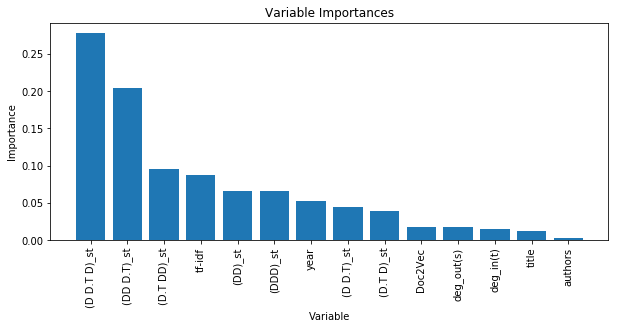

In [19]:
# Plot variable importance
import matplotlib.pyplot as plt

# list of x locations for plotting
x_values = list(range(len(feature_importances)))

# Make a bar chart
plt.figure(figsize=(10,4))
plt.bar(x_values, [importance for (_, importance) in feature_importances], orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, [name for (name, _) in feature_importances], rotation=90)

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## We compute our predictions on the data used for the Kaggle evaluation

In [29]:
# Predictions to submit

predictions = base_model.predict(testing_features).reshape(-1)

predictions = zip(range(len(testing_features)), predictions)

with open("predictions/RF_predictions.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["id", "category"])
    for row in predictions:
        csv_out.writerow(row)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
